In [1]:
time_idx = 0 ## the time index value within the hour - usually there are 11 index values

**Load python libraries**

In [2]:
%matplotlib inline
import boto3
import botocore
import requests
from dask.distributed import Client, progress
import netCDF4
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display

from modules.GOESR_functions import goes_lat_lon_reproj, get_s3_keys
from modules.plotter import loadCPT

**Connect to Dask Distributed Cluster**

Set the `memory_limit` parameter in `Client()` if dask doesn't auto detect your memory limit accurately later on in the notebook. You will know this is occurring if processes start to get killed due to memory limit errors.

In [3]:
from dask.distributed import Client
daskclient = Client(processes=True, n_workers=3, memory_limit='8GB')
daskclient

Client Scheduler: tcp://127.0.0.1:33060 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 48 Memory: 24.00 GB


**Set up access to S3 bucket using `boto3` and a low-level client**

Rather than setting up access key and ID, we will use a low-level client to request data anonymously.

In [4]:
# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

Let's check out what is in the NOAA GOES AWS bucket. For more information on each of the products, see this [documentation](https://docs.opendata.aws/noaa-goes16/cics-readme.html). 

In [5]:
bucket_name = 'noaa-goes17'

paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=bucket_name, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

ABI-L1b-RadC/
ABI-L1b-RadF/
ABI-L1b-RadM/
ABI-L2-CMIPC/
ABI-L2-CMIPF/
ABI-L2-CMIPM/
ABI-L2-FDCC/
ABI-L2-FDCF/
ABI-L2-MCMIPC/
ABI-L2-MCMIPF/
ABI-L2-MCMIPM/
GLM-L2-LCFA/


In [6]:
product_name = 'ABI-L2-CMIPC'
year = 2019
day_of_year = 65
hour = 4
band = 13

prefix = product_name + '/' + str(year) + '/' + str(day_of_year).zfill(3)  \
+ '/' + str(hour).zfill(2) + '/OR_'+ product_name + '-M3C' + str(band).zfill(2)
prefix

'ABI-L2-CMIPC/2019/065/04/OR_ABI-L2-CMIPC-M3C13'

In [7]:
keys = get_s3_keys(bucket_name, prefix = prefix)

s3_data_key = [key for key in keys][time_idx] ## specific time between 0 and 11
# s3_data_key = [key for key in keys][0] # selecting the first measurement taken within the hour

**Download netcdf for specified key**

In [8]:
resp = requests.get('https://' + bucket_name + '.s3.amazonaws.com/' + s3_data_key)

In [9]:
file_name = s3_data_key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)
DS

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.128212 ... 0.044268005
  * x                                       (x) float32 -0.069972 ... 0.069972
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength                         (band) float32 ...
    band_id                                 (band) int32 ...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds 

**Convert radiance scan x, y data into derived latitude and longitude values using [this tutorial](https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm).**

In [10]:
lats, lons = goes_lat_lon_reproj(DS)
# print test coordinates
print('{} N, {} W'.format(lats[318,1849],abs(lons[318,1849])))

40.94820022583008 N, 121.76856231689453 W


**Plot using cartopy**

In [11]:
# Converts a CPT file to be used in Python
cpt = loadCPT('/home/sbarc/students/nash/data/Colortables/IR4AVHRR6.cpt')

./results/OR_ABI-L2-CMIPC-M3C13_G17_s20190650402189_e20190650404573_c20190650405017.png


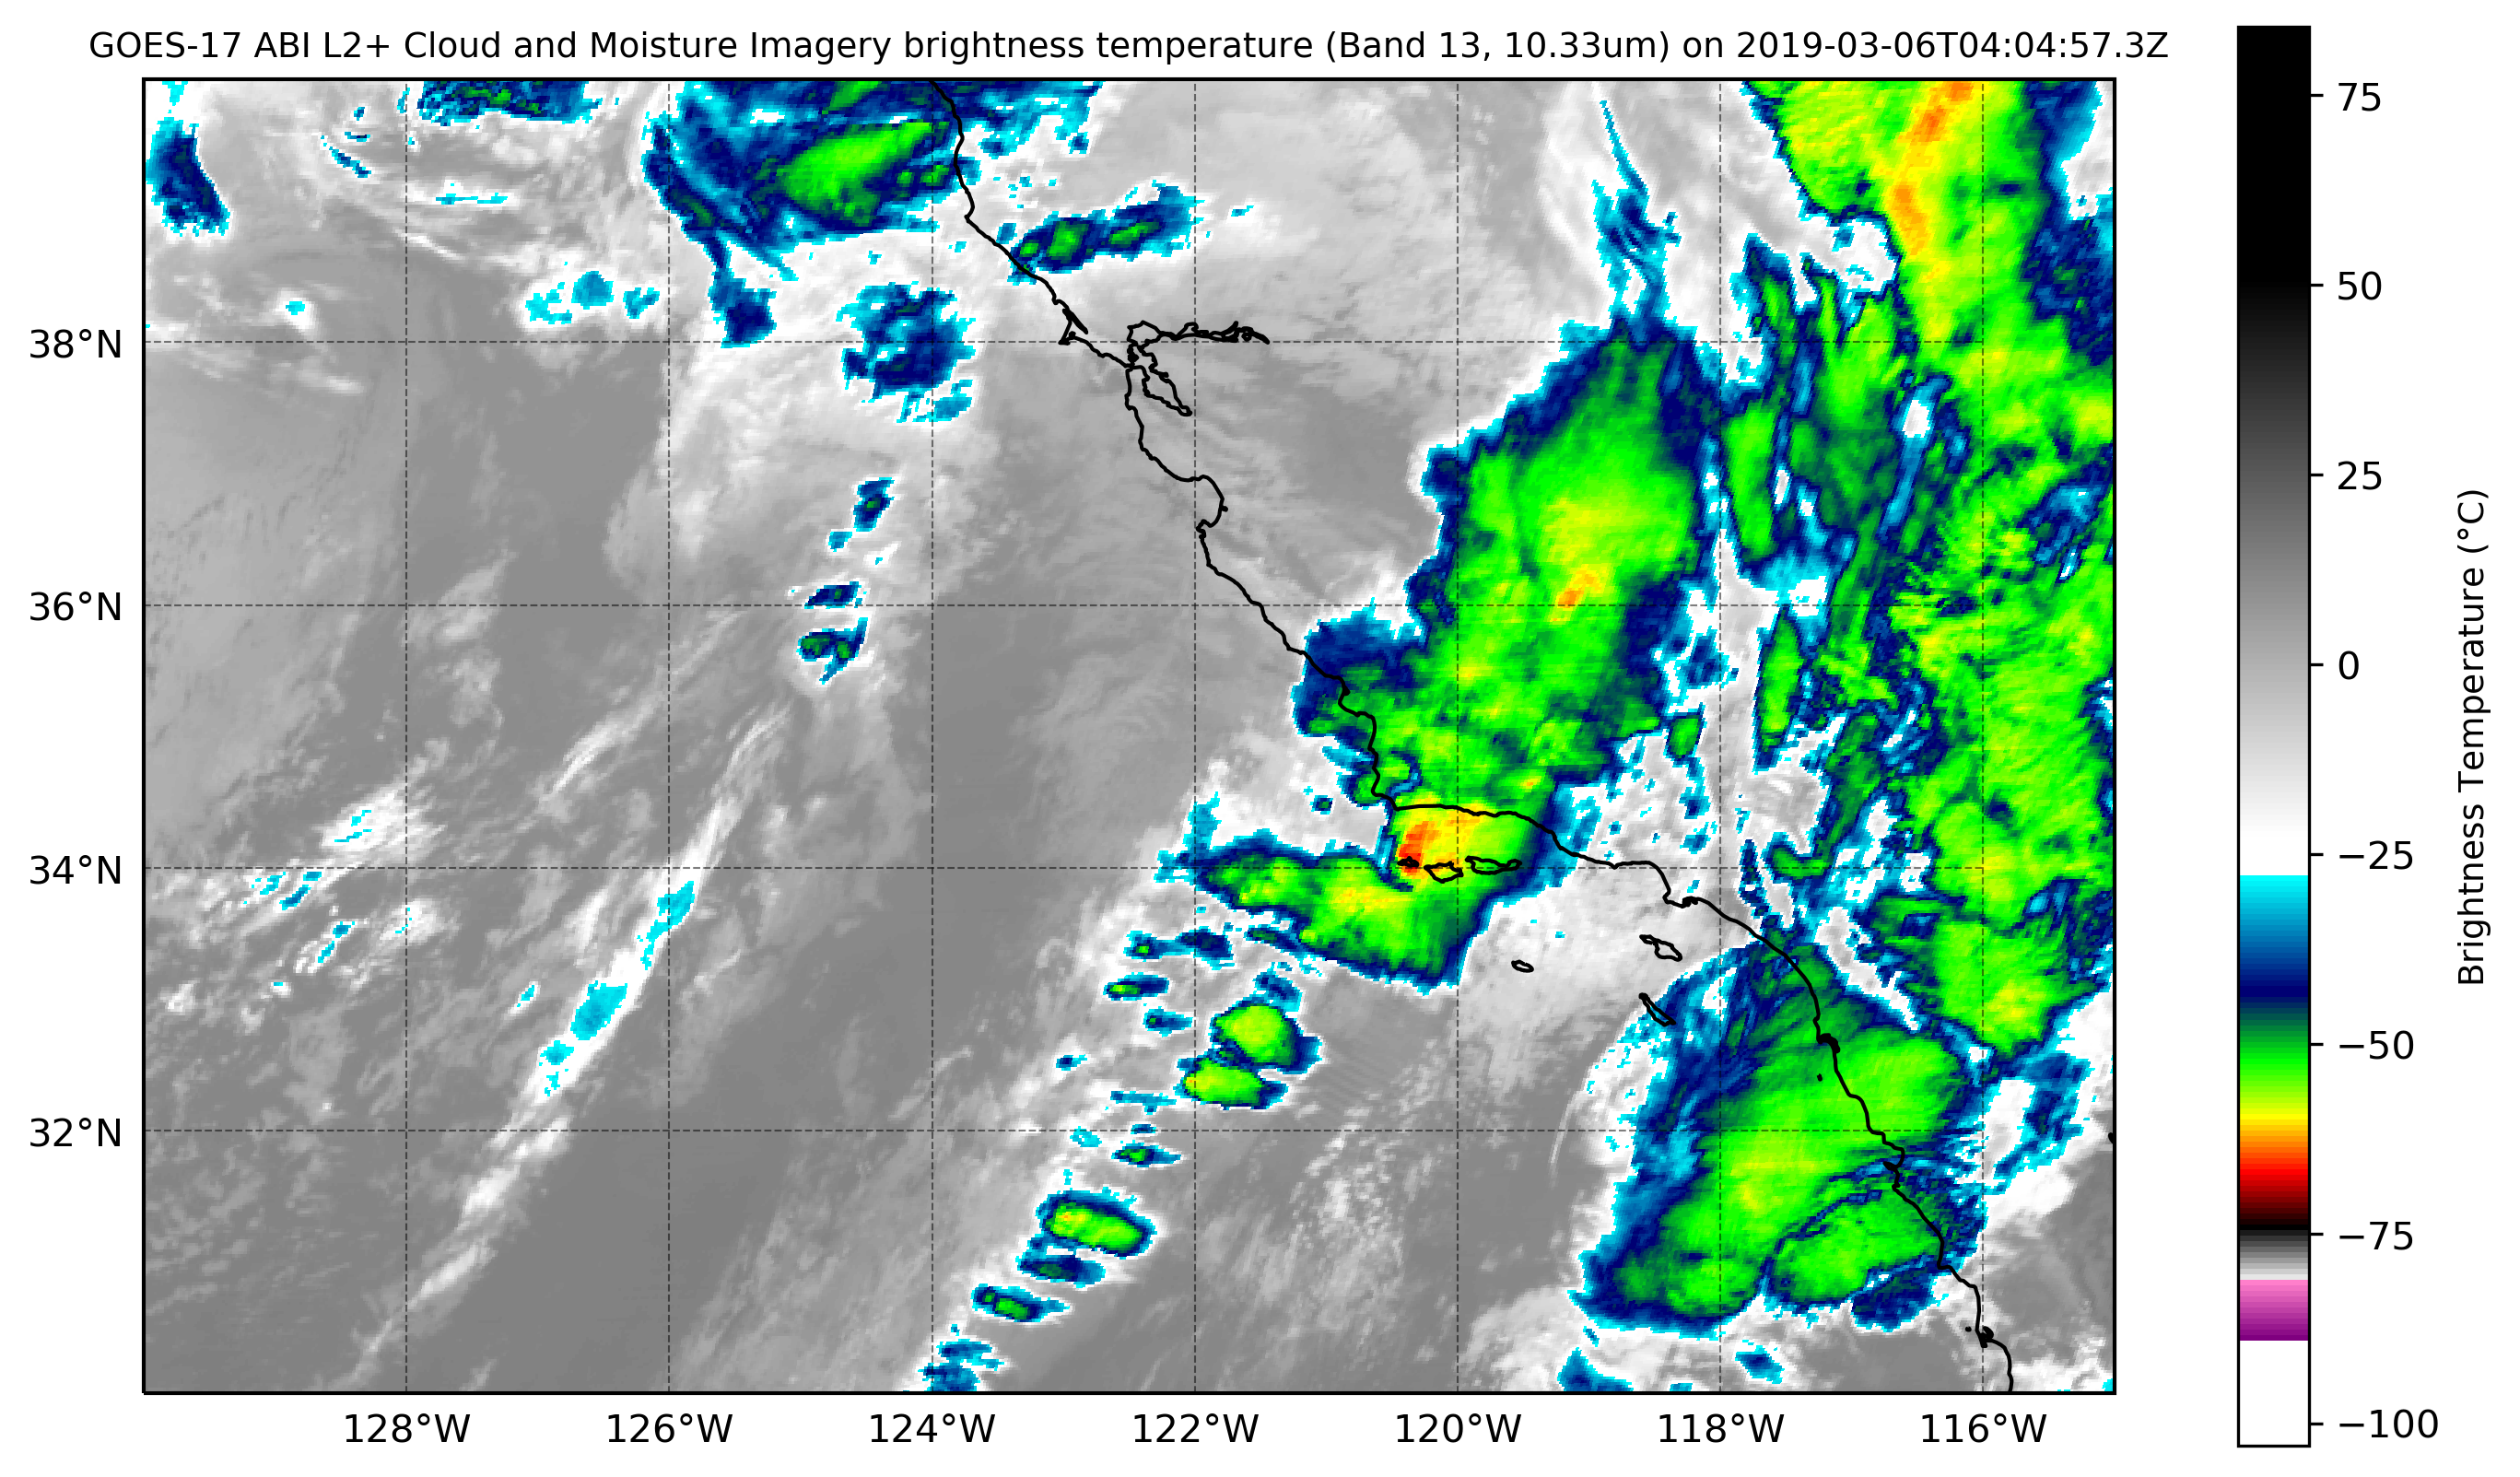

<Figure size 3450x2400 with 0 Axes>

In [13]:
fig = plt.figure(figsize=(11.5,8))
fig.dpi = 300
fname = './results/' + file_name
fmt = 'png'

results = DS.CMI - 273.15 ## Convert to Celsius
ext = (-130., -115.0, 30.0, 40.0)

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ax = plt.axes(projection=mapcrs)
ax.set_extent(ext, crs=mapcrs)

cm = ax.pcolormesh(lons.data, lats.data, results, transform=datacrs, cmap=cpt, vmin=-103, vmax=84)
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-130., -114., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 42, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
coast = ax.coastlines(resolution='10m')

band_info = '(Band ' + str(DS.band_id.values[0]) + ', ' \
+ str(DS.band_wavelength.values[0]) + DS.band_wavelength.units + ')'
plt.title('GOES-17 {0} {1} on {2}'.format(DS.CMI.long_name, band_info, DS.time_coverage_end), 
          fontsize=8)


# Add a color bar
cbar = plt.colorbar(cm, shrink=0.85, orientation='vertical')

Unit = "Brightness Temperature ($\mathrm{\degree C}$)"
cbar.set_label(Unit, fontsize=9)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))